## Dataset and Dataloaders

In [12]:
# # Setting up google drive 
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# import sys
# sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import OneCycleLR
import my_utils as mu
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

# Training data transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalize the image with mean and std
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

# Testing data transforms
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_dataset = CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

# Define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [4]:
class Model(torch.nn.Module):
    def __init__(self, input_channels=3, output_channels=64, num_blocks=3, num_classes=10):
        super(Model, self).__init__()
        self.backbone = nn.ModuleList([Block(input_channels if i == 0 else output_channels * (2 ** (i-1)), 
                                                output_channels * (2 ** i)) for i in range(num_blocks)])
        self.classifier = Classifier(output_channels * (2 ** (num_blocks - 1)), num_classes)

    def forward(self, x):
        for block in self.backbone:
            x = block(x)
        x = self.classifier(x)
        return x

class Block(torch.nn.Module):
    def __init__(self, input_channels, output_channels, k=3, kernel_size=3):
        super(Block, self).__init__()
        self.linear_layer = nn.Linear(input_channels, k)
        self.conv_layers = nn.ModuleList([nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, padding=kernel_size//2) for i in range(k)])
        self.relu = nn.ReLU(inplace=True)
        self.bn2d = nn.BatchNorm2d(output_channels)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.skip = nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=1)

    def forward(self, x):
        a = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)
        a = self.relu(self.linear_layer(a))
        a = a.view(x.size(0), -1, 1, 1)
        O = sum([a[:, k:k+1] * self.conv_layers[k](x) for k in range(a.size(1))])
        O = self.bn2d(O)
        O += self.skip(x)
        O = self.relu(O)
        return self.maxpool(O)

class Classifier(torch.nn.Module):
    def __init__(self, num_inputs, num_classes):
        super(Classifier, self).__init__()
        self.linear_layer = nn.Linear(num_inputs, num_classes)

    def forward(self, x):
        f = F.adaptive_avg_pool2d(x, 1)
        f = f.flatten(1)
        output = self.linear_layer(f)
        return output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

# Define your model, optimizer, loss function, and data iterators
input_channels = 3
output_channels = 64
num_blocks = 4
num_classes = 10
num_epochs = 30

## Loss and Optimizer

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

# Define your model, optimizer, loss function, and data iterators
input_channels = 3
output_channels = 64
num_blocks = 4
num_classes = 10
num_epochs = 30

# Instantiate the model
model = Model(input_channels=input_channels, output_channels=output_channels, num_blocks=num_blocks, num_classes=num_classes).to(device)
print(model)

# Define the optimizer
initial_lr = 0.03
optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, nesterov=True, weight_decay=1e-4)
steps_per_epoch = len(train_dataloader)

# Define the OneCycleLR scheduler
scheduler = OneCycleLR(optimizer, max_lr=0.3, steps_per_epoch=steps_per_epoch, epochs=num_epochs, pct_start=10/num_epochs)

# Define the loss function
loss = nn.CrossEntropyLoss()

Using device: cuda
NVIDIA A40
Model(
  (backbone): ModuleList(
    (0): Block(
      (linear_layer): Linear(in_features=3, out_features=3, bias=True)
      (conv_layers): ModuleList(
        (0-2): 3 x Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (bn2d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Block(
      (linear_layer): Linear(in_features=64, out_features=3, bias=True)
      (conv_layers): ModuleList(
        (0-2): 3 x Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (bn2d): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Block(
      (linear_layer): Linear(in_features=12

## Training Script

In [6]:
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, scheduler, device):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.d2l.Timer()
    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            nn.utils.clip_grad_value_(model.parameters(), 0.1)
            optimizer.step()
            scheduler.step()  # Update the learning rate
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.200, train acc 0.931, test acc 0.855
3615.1 examples/sec on cuda


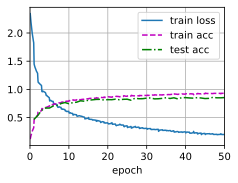

In [7]:
trainf(model, train_dataloader, test_dataloader, loss, num_epochs, optimizer, scheduler, device)